#RNN
Recurrent Neural Netwotk son de las más usadas para señales temporales. 


In [ ]:
import os, gzip, json, re
from plotnine import *
import pandas as pd
import io, os, time, re
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd

%matplotlib inline
from IPython.display import display, Markdown, Image, clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import \
    RMSprop, Adam, SGD
from tqdm.keras import TqdmCallback
import six

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



In [ ]:
base_dir = "drive/MyDrive/airdata"
data_dir = os.path.join(
    os.getcwd(),
    base_dir
)
airdata = []

display(Markdown(f"Listing data files from: {data_dir}"))

generator = (file for file in os.listdir(data_dir) if (file.find(".json.gz") > 0))
for filegz in generator:
    display(Markdown(f"* Loading {filegz}"))
    try:
        with gzip.open(os.path.join(data_dir, filegz), 'rt') as file:
            for (i, line) in enumerate(file):
                #print(f"{filegz}:{i}", line.strip())
                json_line = json.loads(line.strip())
                airdata.append(json_line)
                    
    except EOFError:
        continue
    except Exception as e:
        print(f"Error while reading file {filegz}", type(e))
        raise e
display(Markdown("Done!"))

Listing data files from: /content/drive/MyDrive/airdata

* Loading air-20210212-060408.json.gz

* Loading air-20210212-060529.json.gz

* Loading air-20210212-060534.json.gz

* Loading air-20210212-153737.json.gz

* Loading air-20210212-153808.json.gz

* Loading air-20210308-213952.json.gz

* Loading air-20210212-060545.json.gz

* Loading air-20210212-153921.json.gz

* Loading air-20210415-234052.json.gz

* Loading air-20210308-214511.json.gz

* Loading air-20210218-233000.json.gz

* Loading air-20210326-110304.json.gz

Done!

In [ ]:
df = pd.DataFrame(airdata)
df["datetime"] = pd.to_datetime(df["datetime"], unit='s')
df["hour"] = [dt.hour for dt in df.datetime]
df.head()

,temperature,pressure,humidity,gasResistance,IAQ,iaqAccuracy,datetime,hour
0,21.54,777.41,43.93,151328,37.5,1,2021-02-12 06:04:09.089621067,6
1,21.56,777.41,43.89,152702,35.6,1,2021-02-12 06:04:12.087778807,6
2,21.53,777.41,43.97,151328,37.5,1,2021-02-12 06:04:15.072475433,6
3,21.51,777.41,44.03,151464,38.5,1,2021-02-12 06:04:18.070170164,6
4,21.51,777.41,44.05,152425,36.9,1,2021-02-12 06:04:21.061994791,6


In [ ]:
display(Markdown(f"* Rango de fechas obtenidas: {df.datetime.min()} - {df.datetime.max()}"))
display(Markdown(f"* Número de registros: {df.shape[0]:3,}"))
display(Markdown(f"* Promedio de IAQ: {df.IAQ.mean():.2f} desviación estándar: {df.IAQ.std():.2f}"))

* Rango de fechas obtenidas: 2021-02-12 06:04:09.089621067 - 2021-04-24 22:16:20.885603666

* Número de registros: 2,068,167

* Promedio de IAQ: 161.24 desviación estándar: 72.85

In [ ]:
# Split and Scaling
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
#X = df_train.loc[:, useful_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(df_train.drop('datetime',axis=1))
X_test = min_max_scaler.transform(df_test.drop('datetime',axis=1))

In [ ]:
def build_dataset(X, Y, hist_size):
    '''
    Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
    Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
    '''
    n_samples = Y.shape[0] - hist_size
    x = np.zeros((n_samples, hist_size, X.shape[1]))
    y = np.zeros((n_samples))

    for ind in range(n_samples):    
        x[ind] = X[ind : ind + hist_size]
        y[ind] = Y[ind + hist_size]
    return x, y

time_steps = 4
x_train, y_train = build_dataset(X=X_train, 
                                 Y=X_train[:,-4], 
                                 hist_size=time_steps)
x_test,  y_test  = build_dataset(X=X_test,  
                                 Y=X_test[:,-4],  
                                 hist_size=time_steps)

In [ ]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=256))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               67584     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 67,841
Trainable params: 67,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
rnn_model.compile(loss='mse', optimizer='rmsprop')

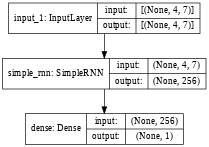

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(rnn_model, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
# Weights in the first layer (simpleRNN, Input does not count as layer)
A, B, C = rnn_model.layers[0].get_weights()
print(A.shape)
print(B.shape)
print(C.shape)


(7, 256)
(256, 256)
(256,)


In [ ]:
# Weights in the second layer (FullyConnected)
W, b = rnn_model.layers[1].get_weights()
print(W.shape)
print(b.shape)

(256, 1)
(1,)


In [ ]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=100, batch_size=256, validation_split=0.1)

Epoch 1/100
5817/5817 [==============================] - 33s 5ms/step - loss: 0.0013 - val_loss: 1.0936e-04
Epoch 2/100
5817/5817 [==============================] - 29s 5ms/step - loss: 6.4063e-05 - val_loss: 5.3160e-05
Epoch 3/100
5817/5817 [==============================] - 29s 5ms/step - loss: 4.0937e-05 - val_loss: 1.0458e-04
Epoch 4/100
5817/5817 [==============================] - 29s 5ms/step - loss: 3.1350e-05 - val_loss: 3.8534e-05
Epoch 5/100
5817/5817 [==============================] - 29s 5ms/step - loss: 2.5779e-05 - val_loss: 4.0155e-05
Epoch 6/100
5817/5817 [==============================] - 29s 5ms/step - loss: 2.2607e-05 - val_loss: 3.0702e-05
Epoch 7/100
5817/5817 [==============================] - 30s 5ms/step - loss: 1.9226e-05 - val_loss: 7.6249e-05
Epoch 8/100
5817/5817 [==============================] - 29s 5ms/step - loss: 1.7451e-05 - val_loss: 7.7508e-06
Epoch 9/100
5817/5817 [==============================] - 29s 5ms/step - loss: 1.5617e-05 - val_loss: 1.2755e

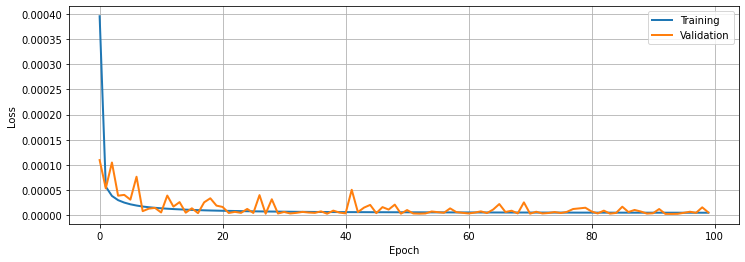

In [ ]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(1654529, 1)
(413630, 1)


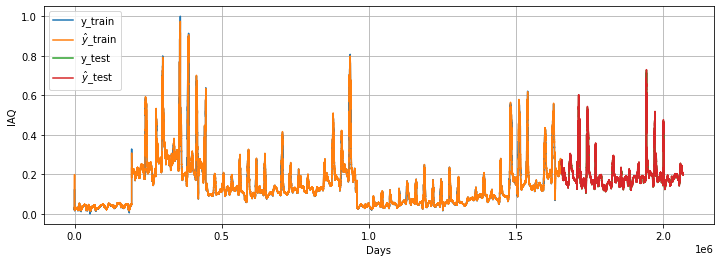

In [22]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test)) # Para poder imprimir test delante de train

plt.figure(figsize=(12, 4))
plt.plot(x_ticks[:len(y_train)], y_train)
plt.plot(x_ticks[:len(y_train)], y_train_hat)
plt.plot(x_ticks[len(y_train):], y_test)
plt.plot(x_ticks[len(y_train):], y_test_hat)
plt.ylabel('IAQ')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()
plt.show()

In [21]:
print(x_test)

[[[0.66666667 0.67723343 0.42649341 ... 0.0896     1.         0.86956522]
  [0.66666667 0.68011527 0.42629946 ... 0.0886     1.         0.86956522]
  [0.66523297 0.67723343 0.42707525 ... 0.089      1.         0.86956522]
  [0.66523297 0.68011527 0.42707525 ... 0.0898     1.         0.86956522]]

 [[0.66666667 0.68011527 0.42629946 ... 0.0886     1.         0.86956522]
  [0.66523297 0.67723343 0.42707525 ... 0.089      1.         0.86956522]
  [0.66523297 0.68011527 0.42707525 ... 0.0898     1.         0.86956522]
  [0.66379928 0.6815562  0.428045   ... 0.0902     1.         0.86956522]]

 [[0.66523297 0.67723343 0.42707525 ... 0.089      1.         0.86956522]
  [0.66523297 0.68011527 0.42707525 ... 0.0898     1.         0.86956522]
  [0.66379928 0.6815562  0.428045   ... 0.0902     1.         0.86956522]
  [0.66379928 0.68011527 0.42823894 ... 0.0914     1.         0.86956522]]

 ...

 [[0.82437276 0.48270893 0.46179209 ... 0.206      1.         0.17391304]
  [0.82437276 0.48270893 0